# Histopathologic Cancer Detection Dataset

This dataset contains a large number of small pathology images used for **binary classification**. Each image corresponds to a small patch extracted from a whole-slide image of lymph node tissue. The goal is to classify whether the **central 32x32 pixel region** of each image contains **tumor tissue** or not.

The files provided by [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data), are:
- `train/` folder: contains training images.
- `test/` folder: contains images for which labels need to be predicted.
- `train_labels.csv`: contains the ground truth labels for images in the training set.
  - `id`: image file name without extension
- `label`: 
  - **Positive labels (1)** correspond to images where the **central 32x32 px region** of the patch contains **at least one pixel of tumor tissue**.  
  - **Negative labels (0)** correspond to images where the **central region contains no tumor tissue**.  
  - **Outer region of the patch**: This area is included to support **fully-convolutional models** that avoid zero-padding. Tumor tissue in the outer region **does not influence the label**.


## Dataset Size
- Training images: 220,025  
- Test images: 57,500  
- Image format: PNG  
- Image size: 96x96 pixels (RGB)

## Reference
- Kaggle competition: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/)
- Original PCam benchmark dataset: [PCam: PatchCamelyon](https://github.com/basveeling/pcam)


In [42]:
# ============================================================================
# PART 1: DATASET CLASS AND BASIC SETUP
# ============================================================================

import os
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set style for better-looking plots
#sns.set_style("whitegrid")
#plt.rcParams['figure.facecolor'] = 'white'

plt.style.use('seaborn-v0_8-paper')

class HistopathologicCancerDataset(Dataset):
    """
    Histopathologic Cancer Detection dataset class compatible with PyTorch.
    
    This dataset contains 96x96 pixel histopathologic images for binary 
    classification (0 = no cancer, 1 = metastatic cancer tissue present).
    
    Parameters
    ----------
    root_dir : str
        Root directory containing the dataset (should contain 'train' and/or 'test' folders).
    data_type : str, default='train'
        Type of dataset to load. Must be 'train' or 'test'.
    transform : callable, optional
        A function/transform to apply to each image (e.g., torchvision.transforms).
    labels_file : str, optional
        Path to the CSV file containing labels. Required if data_type='train'.
        Should have columns: 'id' (image filename without extension) and 'label' (0 or 1).
    
    Attributes
    ----------
    data_dir : str
        Path to the image directory (train or test).
    image_ids : list
        List of image IDs (filenames without extensions).
    labels : dict or None
        Dictionary mapping image IDs to labels (only for training data).
    transform : callable
        Transform to apply to images.
    
    Methods
    -------
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Returns the image and label at the given index, applying the transform if specified.
    visualize(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        Display a single image (tensor or NumPy array), un-normalizing if needed.
    get_class_distribution()
        Returns the distribution of classes in the dataset (only for training data).
    """
    
    def __init__(self, root_dir, data_type='train', transform=None, labels_file=None):
        """
        Initialize the dataset.
        
        Parameters
        ----------
        root_dir : str
            Root directory containing 'train' and/or 'test' folders
        data_type : str
            'train' or 'test'
        transform : callable, optional
            Transform to apply to images
        labels_file : str, optional
            Path to CSV file with labels (required for train)
        """
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform
        
        # Set the data directory based on type
        if data_type == 'train':
            self.data_dir = os.path.join(root_dir, 'train')
            
            # Load labels from CSV file
            if labels_file is None:
                # Try default location
                labels_file = os.path.join(root_dir, 'train_labels.csv')
            
            if not os.path.exists(labels_file):
                raise FileNotFoundError(
                    f"Labels file not found at {labels_file}. "
                    "Please provide the path to train_labels.csv"
                )
            
            # Read labels CSV
            labels_df = pd.read_csv(labels_file)
            
            # Create a dictionary mapping image_id to label
            self.labels = dict(zip(labels_df['id'], labels_df['label']))
            
            # Get list of image IDs from the labels file
            self.image_ids = list(self.labels.keys())
            
        elif data_type == 'test':
            self.data_dir = os.path.join(root_dir, 'test')
            self.labels = None
            
            # Get list of all image files in test directory
            self.image_ids = [
                f.replace('.tif', '') for f in os.listdir(self.data_dir) 
                if f.endswith('.tif')
            ]
            
        else:
            raise ValueError("data_type must be 'train' or 'test'")
        
        # Verify that the data directory exists
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(
                f"Data directory not found at {self.data_dir}. "
                f"Please ensure the dataset is properly extracted."
            )
    
    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Parameters
        ----------
        idx : int
            Index of the sample to retrieve
            
        Returns
        -------
        tuple
            (image, label) where image is a PIL Image or transformed tensor,
            and label is an integer (0 or 1) for train data, or the image_id for test data
        """
        # Get image ID
        img_id = self.image_ids[idx]
        
        # Construct image path - images are .tif format
        img_path = os.path.join(self.data_dir, f"{img_id}.tif")
        
        # Load image using PIL
        img = Image.open(img_path).convert('RGB')
        
        # Apply transform if specified
        if self.transform:
            img = self.transform(img)
        
        # Return image and label (for train) or image_id (for test)
        if self.data_type == 'train':
            label = self.labels[img_id]
            return img, label
        else:
            # For test data, return the image_id instead of a label
            return img, img_id
    
    def visualize(self, img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
        """
        Display a single image (tensor or NumPy array), denormalizing if needed.
        
        Parameters
        ----------
        img : torch.Tensor or np.ndarray or PIL.Image
            Image to visualize
        mean : tuple
            Mean values used for normalization
        std : tuple
            Standard deviation values used for normalization
        """
        if isinstance(img, torch.Tensor):
            # Convert tensor to NumPy
            npimg = img.cpu().numpy()
            
            # Check if tensor is CHW (3,H,W), then permute to HWC
            if npimg.shape[0] == 3 and len(npimg.shape) == 3:
                npimg = np.transpose(npimg, (1, 2, 0))  # CHW -> HWC
            
            # Denormalize
            mean_arr = np.array(mean).reshape(1, 1, 3)
            std_arr = np.array(std).reshape(1, 1, 3)
            npimg = npimg * std_arr + mean_arr
            npimg = np.clip(npimg, 0, 1)
            
            plt.imshow(npimg)
        elif isinstance(img, Image.Image):
            # PIL Image
            plt.imshow(img)
        else:
            # NumPy array, assume already HWC
            plt.imshow(img)
        
        plt.axis('off')
        plt.show()
    
    def get_class_distribution(self):
        """
        Get the distribution of classes in the dataset.
        Only available for training data.
        
        Returns
        -------
        dict
            Dictionary with class counts: {0: count_no_cancer, 1: count_cancer}
        """
        if self.data_type != 'train' or self.labels is None:
            raise ValueError("Class distribution only available for training data")
        
        label_values = list(self.labels.values())
        distribution = {
            0: label_values.count(0),
            1: label_values.count(1)
        }
        
        print(f"Class Distribution:")
        print(f"  No Cancer (0): {distribution[0]:,} images ({distribution[0]/len(label_values)*100:.2f}%)")
        print(f"  Cancer (1): {distribution[1]:,} images ({distribution[1]/len(label_values)*100:.2f}%)")
        
        return distribution

In [43]:
# ============================================================================
# PART 2: DATA EXPLORATION AND VISUALIZATION
# ============================================================================

# Define your transforms (simple normalization for visualization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
train_dataset = HistopathologicCancerDataset(
    root_dir='./data',
    data_type='train',
    transform=transform,
    labels_file='./data/train_labels.csv'
)

print(f"Dataset size: {len(train_dataset)}")
train_dataset.get_class_distribution()

Dataset size: 220025
Class Distribution:
  No Cancer (0): 130,908 images (59.50%)
  Cancer (1): 89,117 images (40.50%)


{0: 130908, 1: 89117}

In [44]:
# ============================================================================
# 1. LOAD AND EXPLORE THE LABELS
# ============================================================================

# Load the labels CSV
labels_df = pd.read_csv('./data/train_labels.csv')

print("\n" + "=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print("\nFirst 5 rows of the dataset:")
print(labels_df.head())

print("\n" + "=" * 70)
print("BASIC STATISTICS")
print("=" * 70)
print(f"\nTotal number of images: {len(labels_df):,}")
print(f"Number of unique IDs: {labels_df['id'].nunique():,}")


DATASET OVERVIEW

First 5 rows of the dataset:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

BASIC STATISTICS

Total number of images: 220,025
Number of unique IDs: 220,025


In [45]:
# ============================================================================
# 2. CHECK FOR DUPLICATES
# ============================================================================

print("\n" + "=" * 70)
print("DUPLICATE CHECK")
print("=" * 70)

duplicates = labels_df[labels_df.duplicated(keep=False)]
if len(duplicates) > 0:
    print(f"⚠️  Found {len(duplicates)} duplicate entries:")
    print(duplicates)
else:
    print("✓ No duplicate IDs found")



DUPLICATE CHECK
✓ No duplicate IDs found



CLASS DISTRIBUTION
label
0    130908
1     89117
Name: count, dtype: int64

Class 0 (No Cancer): 130,908 images (59.50%)
Class 1 (Cancer): 89,117 images (40.50%)


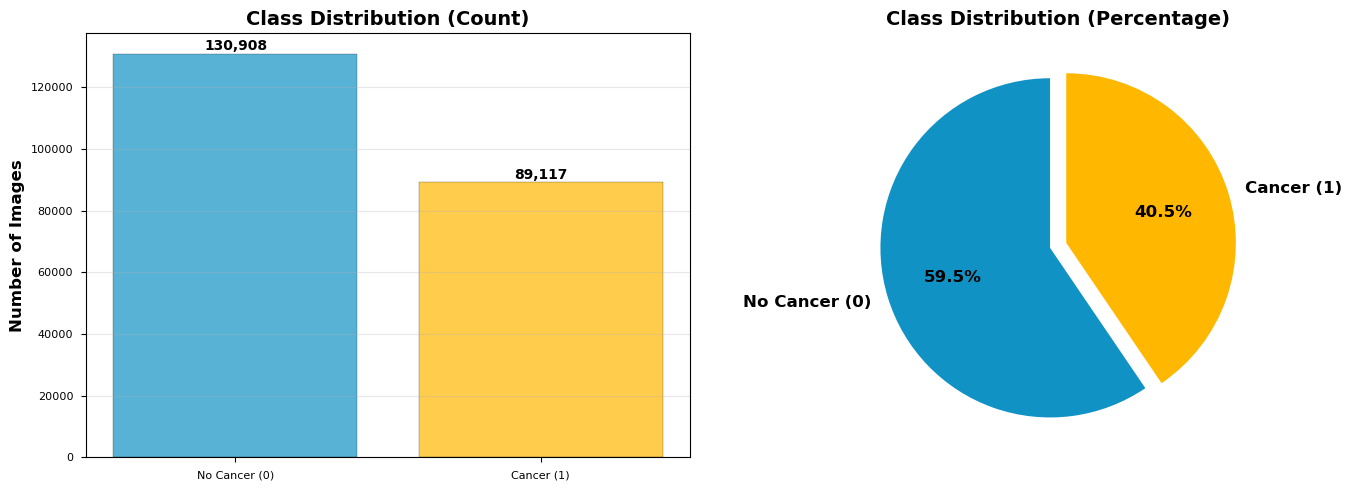

In [46]:
# ============================================================================
# 3. CLASS DISTRIBUTION
# ============================================================================

print("\n" + "=" * 70)
print("CLASS DISTRIBUTION")
print("=" * 70)

class_counts = labels_df['label'].value_counts().sort_index()
print(class_counts)
print(f"\nClass 0 (No Cancer): {class_counts[0]:,} images ({class_counts[0]/len(labels_df)*100:.2f}%)")
print(f"Class 1 (Cancer): {class_counts[1]:,} images ({class_counts[1]/len(labels_df)*100:.2f}%)")

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['No Cancer (0)', 'Cancer (1)'], class_counts.values, 
            color=["#1192c5", "#ffb700"], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ["#1192c5", "#ffb700"]
explode = (0.05, 0.05)
axes[1].pie(class_counts.values, labels=['No Cancer (0)', 'Cancer (1)'], 
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [47]:
# ============================================================================
# 4. GET IMAGE IDs BY CLASS
# ============================================================================

imgpath = "./data/train/"  # training data is stored in this folder
malignant = labels_df.loc[labels_df['label'] == 1]['id'].values  # cancer cases
normal = labels_df.loc[labels_df['label'] == 0]['id'].values     # normal cases

print("\n" + "=" * 70)
print("SAMPLE IMAGE IDs")
print("=" * 70)
print('Normal (No Cancer) IDs (first 3):')
print(normal[0:3])
print('\nMalignant (Cancer) IDs (first 3):')
print(malignant[0:3])


SAMPLE IMAGE IDs
Normal (No Cancer) IDs (first 3):
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08']

Malignant (Cancer) IDs (first 3):
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [48]:
# ============================================================================
# 5. VISUALIZATION FUNCTION
# ============================================================================

def plot_fig(ids, title, nrows=5, ncols=15, add_border=True):
    """
    Plot a grid of images given their IDs.
    
    Parameters
    ----------
    ids : array-like
        Image IDs to display
    title : str
        Title for the figure
    nrows : int
        Number of rows in the grid
    ncols : int
        Number of columns in the grid
    add_border : bool
        Whether to add a white border to images
    """
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for i, img_id in enumerate(ids[:nrows * ncols]):
        fname = os.path.join(imgpath, img_id + '.tif')
        
        try:
            img = Image.open(fname)
            
            # Add white border for visibility (optional)
            if add_border:
                idcol = ImageDraw.Draw(img)
                idcol.rectangle(((0, 0), (95, 95)), outline='white', width=2)
            
            # Plot the image
            row = i // ncols
            col = i % ncols
            
            if nrows == 1:
                axes = ax[col]
            else:
                axes = ax[row, col]
            
            axes.imshow(np.array(img))
            axes.axis('off')
            
        except Exception as e:
            print(f"Error loading image {img_id}: {e}")
    
    plt.suptitle(title, y=0.98, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()



VISUALIZING SAMPLE IMAGES

Plotting malignant (cancer) cases...


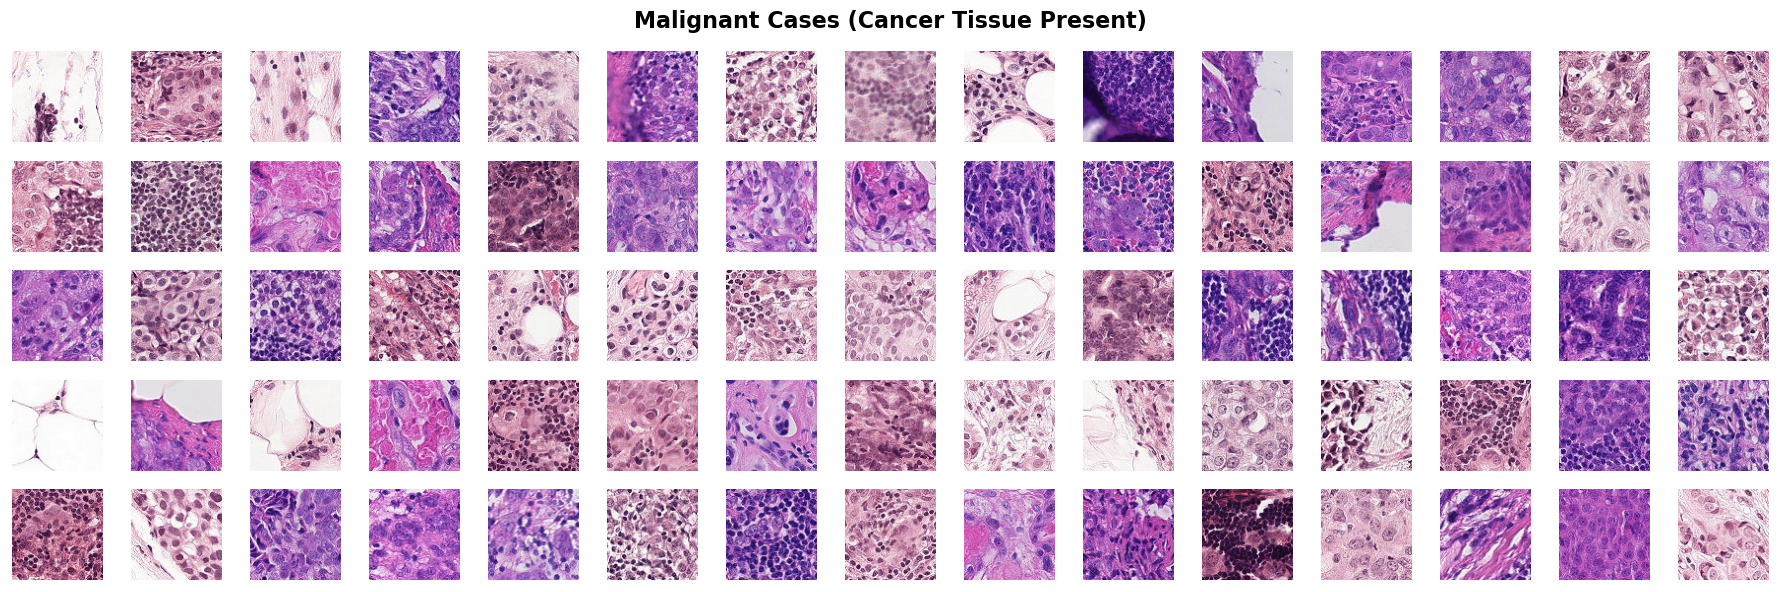

Plotting normal (no cancer) cases...


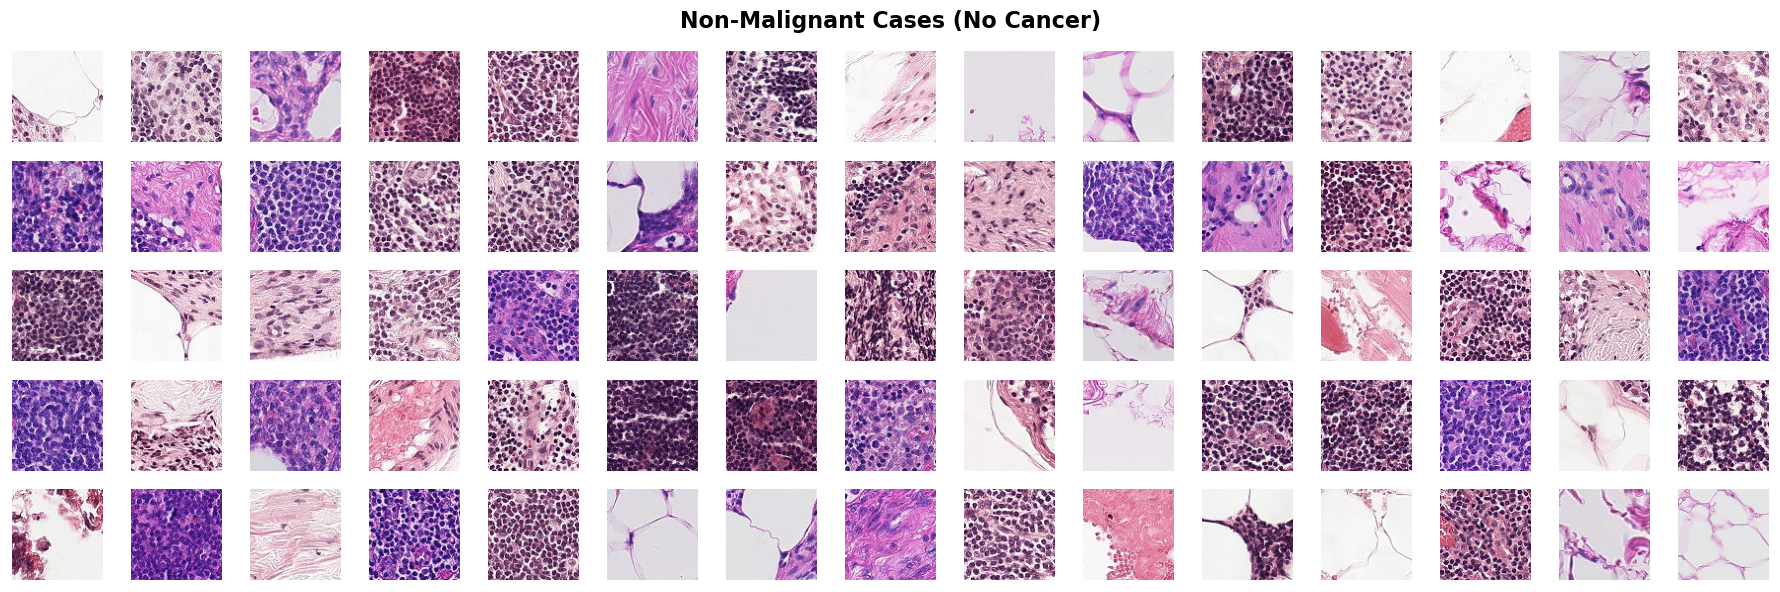

In [49]:
# ============================================================================
# 6. VISUALIZE SAMPLE IMAGES
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZING SAMPLE IMAGES")
print("=" * 70)

# Plot malignant cases
print("\nPlotting malignant (cancer) cases...")
plot_fig(malignant, 'Malignant Cases (Cancer Tissue Present)', nrows=5, ncols=15)

# Plot normal cases
print("Plotting normal (no cancer) cases...")
plot_fig(normal, 'Non-Malignant Cases (No Cancer)', nrows=5, ncols=15)


Creating side-by-side comparison...


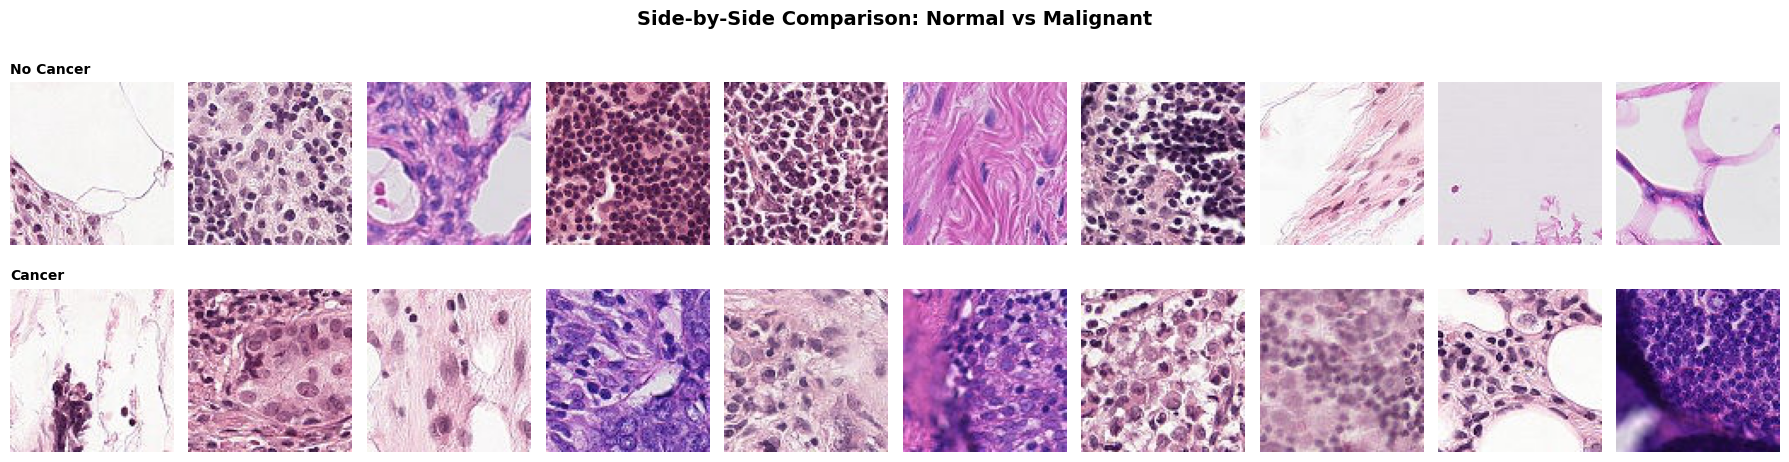

In [50]:
# ============================================================================
# 7. SIDE-BY-SIDE COMPARISON
# ============================================================================

print("\nCreating side-by-side comparison...")

def plot_comparison(normal_ids, malignant_ids, n_samples=10):
    """
    Plot normal and malignant images side by side for comparison.
    
    Parameters
    ----------
    normal_ids : array-like
        IDs of normal images
    malignant_ids : array-like
        IDs of malignant images
    n_samples : int
        Number of samples to display for each class
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(18, 5))
    
    # Plot normal cases
    for i in range(n_samples):
        fname = os.path.join(imgpath, normal_ids[i] + '.tif')
        img = Image.open(fname)
        axes[0, i].imshow(np.array(img))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('No Cancer', fontsize=10, fontweight='bold', loc='left')
    
    # Plot malignant cases
    for i in range(n_samples):
        fname = os.path.join(imgpath, malignant_ids[i] + '.tif')
        img = Image.open(fname)
        axes[1, i].imshow(np.array(img))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Cancer', fontsize=10, fontweight='bold', loc='left')
    
    plt.suptitle('Side-by-Side Comparison: Normal vs Malignant', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

plot_comparison(normal, malignant, n_samples=10)

# **PART 2 - CNN MODEL TRAINING**

In [51]:
# ============================================================================
# CNN MODEL TRAINING - PART 2
# ============================================================================
# This code should be run AFTER the data exploration code (Part 1)
# It assumes the HistopathologicCancerDataset class is already defined

import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [52]:
# ============================================================================
# CNN ARCHITECTURE
# ============================================================================

class CancerCNN(nn.Module):
    """
    CNN for binary classification of histopathologic images (96x96x3).
    
    Parameters
    ----------
    in_channels : int, default=3
        Number of input channels (RGB images).
    num_classes : int, default=2
        Number of output classes (binary: 0=no cancer, 1=cancer).
    conv_layers : list of tuples, default=[(32,3), (64,3), (128,3)]
        Each tuple defines (out_channels, kernel_size) for conv layers.
    pool_type : str, default='max'
        Type of pooling: 'max' or 'avg'.
    pool_kernel : int, default=2
        Kernel size for pooling.
    pool_stride : int, default=2
        Stride for pooling.
    fc_layers : list of int, default=[256, 128]
        Fully connected layer sizes before output.
    activation : str, default='relu'
        Activation function: 'relu', 'leaky_relu', or 'elu'.
    dropout : float, default=0.5
        Dropout probability for regularization.
    input_size : tuple, default=(96, 96)
        Input image dimensions (height, width).
    """
    
    def __init__(self,
                 in_channels=3,
                 num_classes=2,
                 conv_layers=[(32, 3), (64, 3), (128, 3)],
                 pool_type='max',
                 pool_kernel=2,
                 pool_stride=2,
                 fc_layers=[256, 128],
                 activation='relu',
                 dropout=0.5,
                 input_size=(96, 96)):
        
        super(CancerCNN, self).__init__()

        self.in_channels=in_channels
        self.num_classes=num_classes
        self.conv_layers=conv_layers
        self.pool_type=pool_type
        self.pool_kernel=pool_kernel
        self.pool_stride=pool_stride
        self.activation=activation
        self.dropout=dropout
        self.input_size=input_size
        
        # Select activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation")
        
        
        # Build convolutional layers
        self.conv_blocks = nn.ModuleList()
        current_channels = in_channels
        
        for out_channels, kernel_size in conv_layers:
            conv_block = nn.Sequential(
                nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size, padding=1),
                nn.BatchNorm2d(out_channels),  # Batch normalization
                self.activation,
                nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride) if pool_type == 'max' 
                    else nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
            )
            self.conv_blocks.append(conv_block)
            current_channels = out_channels
        
        # Compute flattened size after conv + pool layers
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_size[0], input_size[1])
            x = dummy
            for block in self.conv_blocks:
                x = block(x)
            flattened_size = torch.flatten(x, start_dim=1).shape[1]
        
        # Build fully connected layers with dropout
        self.fc_layers = nn.ModuleList()
        input_size_fc = flattened_size
        
        for units in fc_layers:
            self.fc_layers.append(nn.Sequential(
                nn.Linear(input_size_fc, units),
                self.activation,
                nn.Dropout(dropout)  # Dropout for regularization
            ))
            input_size_fc = units
        
        # Output layer
        self.output_layer = nn.Linear(input_size_fc, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, height, width).
        
        Returns
        -------
        torch.Tensor
            Output logits of shape (batch_size, num_classes).
        """
        # Convolutional blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        for fc in self.fc_layers:
            x = fc(x)
        
        # Output layer (no activation - we'll use CrossEntropyLoss)
        x = self.output_layer(x)
        
        return x


In [53]:
# ============================================================================
# TRAINING CLASS
# ============================================================================

class CancerTrainer:
    """
    Handles training for the cancer detection model.
    """
    
    def __init__(self, config):
        """
        Initialize trainer with configuration.
        
        Parameters
        ----------
        config : dict
            Configuration dictionary containing:
            - model: PyTorch model
            - data_path: path to dataset
            - batch_size: batch size for training
            - num_epochs: number of training epochs
            - learning_rate: learning rate for optimizer
            - device: 'cuda' or 'cpu'
            - num_workers: number of workers for data loading
        """
        self.model = config["model"]
        self.data_path = config["data_path"]
        self.batch_size = config.get("batch_size", 32)
        self.num_epochs = config.get("num_epochs", 5)
        self.lr = config.get("learning_rate", 0.001)
        self.device = config.get("device", "cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = config.get("num_workers", 0)
        
        # Move model to device
        self.model = self.model.to(self.device)
        
        # Define loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Setup data
        self._setup_data(config)
        
    def _setup_data(self, config):
        """
        Setup datasets and dataloaders with train/val split.
        
        PREPROCESSING AND AUGMENTATION HAPPENS HERE!
        """
        # ========================================================================
        # DATA AUGMENTATION AND PREPROCESSING
        # ========================================================================
        
        # Training transform with augmentation
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),          # Random horizontal flip
            transforms.RandomVerticalFlip(p=0.5),            # Random vertical flip
            transforms.RandomRotation(degrees=20),            # Random rotation
            transforms.ColorJitter(                           # Random color adjustments
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomAffine(                          # Random affine transformations
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),                             # Zoom
                shear=10                                      # Shear transformation
            ),
            transforms.ToTensor(),                            # Convert to tensor (rescale to [0,1])
            transforms.Normalize(                             # Normalize (preprocessing)
                mean=[0.485, 0.456, 0.406],                  # ImageNet mean
                std=[0.229, 0.224, 0.225]                    # ImageNet std
            )
        ])
        
        # Validation/Test transform (no augmentation, only preprocessing)
        val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Validation/Test transform (no augmentation, only preprocessing)
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        # Load full dataset with train transform (for indexing train samples)
        full_dataset = HistopathologicCancerDataset(
            root_dir=self.data_path,
            data_type='train',
            transform=train_transform,
            labels_file=os.path.join(self.data_path, 'train_labels.csv')
        )

        # Optional: use only a subset for fast testing
        subset_size = int(0.01 * len(full_dataset)) # 22,000 instead of 220,000
        full_dataset = torch.utils.data.Subset(full_dataset, list(range(subset_size)))

        
        # Split into train, validation and test set (70/15/15 split)
        total_size = len(full_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size 

        # Split dataset (train + temporary val + test indices)
        train_dataset, val_dataset_temp, test_dataset_temp = random_split(
            full_dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        # Create validation dataset with val_transform (no augmentation)
        val_dataset_full = HistopathologicCancerDataset(
            root_dir=self.data_path,
            data_type='train',
            transform=val_transform,
            labels_file=os.path.join(self.data_path, 'train_labels.csv')
        )
        val_indices = val_dataset_temp.indices
        val_dataset = torch.utils.data.Subset(val_dataset_full, val_indices)

        # Create test dataset with val_transform (no augmentation)
        test_dataset_full = HistopathologicCancerDataset(
            root_dir=self.data_path,
            data_type='train',
            transform=val_transform,
            labels_file=os.path.join(self.data_path, 'train_labels.csv')
        )
        test_indices = test_dataset_temp.indices
        test_dataset = torch.utils.data.Subset(test_dataset_full, test_indices)

        # Create dataloaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True if self.device == 'cuda' else False
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True if self.device == 'cuda' else False
        )

        self.test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True if self.device == 'cuda' else False
        )

        print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test")
        print(f"Batches per epoch (train): {len(self.train_loader)}")
        print(f"Batches per epoch (val): {len(self.val_loader)}")
        print(f"Batches per epoch (test): {len(self.test_loader)}")
    
    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self):
        """Validate the model."""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(self.val_loader)
        val_acc = 100. * correct / total
        
        return val_loss, val_acc
    
    def train(self):
        """Train the model for all epochs."""
        print(f"\n{'='*70}")
        print(f"Starting Training")
        print(f"{'='*70}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.num_epochs}")
        print(f"Batch size: {self.batch_size}")
        print(f"Learning rate: {self.lr}")
        print(f"{'='*70}\n")
        
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        best_val_acc = 0.0
        
        for epoch in range(self.num_epochs):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            epoch_time = time.time() - epoch_start
            
            # Store metrics
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            # Print progress
            print(f"Epoch [{epoch+1}/{self.num_epochs}] "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                  f"Time: {epoch_time:.2f}s")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_model.pth')
                print(f"  → New best validation accuracy: {val_acc:.2f}%")
        
        print(f"\n{'='*70}")
        print(f"Training Complete!")
        print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"{'='*70}\n")
        
        # Store results
        self.train_losses = train_losses
        self.train_accs = train_accs
        self.val_losses = val_losses
        self.val_accs = val_accs
        
        return train_losses, val_losses, train_accs, val_accs
    
    def update_hyperparameters(self, params_dict):
        """
        Update model and training hyperparameters.

        Parameters
        ----------
        params_dict : dict
            Dictionary containing hyperparameters to update:
            - 'n_filters_1', 'n_filters_2', 'dense_units', 'dropout_rate',
            - 'learning_rate', 'batch_size'
        """
        # Update batch size
        if "batch_size" in params_dict:
            self.batch_size = int(round(params_dict["batch_size"]))

        # Update learning rate
        if "learning_rate" in params_dict:
            self.lr = params_dict["learning_rate"]
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = self.lr

        # Update batch size
        if "dropout_rate" in params_dict:
            dropout = int(round(params_dict["dropout_rate"]))

        # Update model layers (if provided)
        conv_layers = []
        if "n_filters_1" in params_dict:
            conv_layers.append((int(round(params_dict["n_filters_1"])), 3))
        else:
            conv_layers.append((self.model.conv_layers[0][0], 3))

        if "n_filters_2" in params_dict:
            conv_layers.append((int(round(params_dict["n_filters_2"])), 3))
        else:
            conv_layers.append((self.model.conv_layers[1][0], 3))

        # Only one dense layer assumed
        dense_units = int(round(params_dict.get("dense_units", self.model.fc_layers[0])))

        # Rebuild model with new hyperparameters
        self.model = CancerCNN(
            conv_layers=conv_layers,
            fc_layers=[dense_units],
            dropout=dropout
        ).to(self.device)

        # Reinitialize optimizer with updated learning rate
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        print(f"Updated hyperparameters: {params_dict}")

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from scipy.stats import norm
from scipy.optimize import minimize
from typing import Dict, List, Tuple, Callable
import warnings
warnings.filterwarnings('ignore')


class BayesianOptimizationCNN:
    """
    Bayesian Optimization for CNN Hyperparameter Tuning
    
    Implements GP-based Bayesian optimization with Expected Improvement
    acquisition function for optimizing CNN architectures.
    """
    
    def __init__(self, trainer: CancerTrainer, 
                 param_bounds: Dict[str, Tuple[float, float]], 
                 n_initial_points: int = 5,
                 n_iterations: int = 20,
                 xi: float = 0.01,
                 random_state: int = 42):
        """
        Initialize Bayesian Optimization
        
        Args:
            trainer: CancerTrainer object
            param_bounds: Dictionary of parameter names and their (min, max) bounds
            n_initial_points: Number of random initial evaluations
            n_iterations: Number of BO iterations
            xi: Exploration-exploitation trade-off parameter for EI
            random_state: Random seed for reproducibility
        """

        self.trainer=trainer
        self.param_bounds = param_bounds
        self.n_initial_points = n_initial_points
        self.n_iterations = n_iterations
        self.xi = xi
        self.random_state = random_state

        np.random.seed(random_state)
        
        # Store observations
        self.X_observed = []
        self.y_observed = []
        
        # Initialize GP with Matern kernel (as recommended in the paper)
        #This represents the prior definition 
        #(this implicitly assume the distribution of the process before seeing any data)
        kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=0.5,
            normalize_y=True,
            n_restarts_optimizer=10,
            random_state=random_state
        )

        
    def _normalize_params(self, params: np.ndarray) -> np.ndarray:
        """Normalize parameters to [0, 1]"""
        normalized = np.zeros_like(params)
        for i, (key, (low, high)) in enumerate(self.param_bounds.items()):
            normalized[i] = (params[i] - low) / (high - low)
        return normalized
    
    def _denormalize_params(self, normalized_params: np.ndarray) -> np.ndarray:
        """Denormalize parameters from [0, 1] to original bounds"""
        params = np.zeros_like(normalized_params)
        for i, (key, (low, high)) in enumerate(self.param_bounds.items()):
            params[i] = normalized_params[i] * (high - low) + low
        return params
    
    def _params_to_dict(self, params: np.ndarray) -> Dict[str, float]:
        """Convert parameter array to dictionary"""
        return {key: params[i] for i, key in enumerate(self.param_bounds.keys())}
    
    def _expected_improvement(self, X: np.ndarray, X_sample: np.ndarray, 
                             y_sample: np.ndarray, gp: GaussianProcessRegressor) -> np.ndarray:
        """
        Expected Improvement acquisition function
        
        Based on Frazier (2018), Section 4.1:
        EI(x) = E[max(f(x) - f(x+), 0)]
        where f(x+) is the best observed value
        
        Args:
            X: Points at which to evaluate EI
            X_sample: Observed input points
            y_sample: Observed output values
            gp: Fitted Gaussian Process model
            
        Returns:
            Expected improvement values at X
        """
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample = gp.predict(X_sample)
        
        # Best observed value (we're maximizing, so take max)
        mu_sample_opt = np.max(y_sample)
        
        with np.errstate(divide='warn'):
            imp = mu - mu_sample_opt - self.xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0
            
        return ei
    
    def _propose_location(self) -> np.ndarray:
        """
        Propose next sampling point by optimizing the acquisition function
        
        Uses multi-start optimization to find the point with highest EI
        """
        dim = len(self.param_bounds)
        min_val = float('inf')
        min_x = None
        
        # Multiple random restarts for robustness
        n_restarts = 25
        for _ in range(n_restarts):
            x0 = np.random.uniform(0, 1, dim)
            
            # Minimize negative EI (equivalent to maximizing EI)
            res = minimize(
                lambda x: -self._expected_improvement(
                    x.reshape(1, -1),
                    np.array(self.X_observed),
                    np.array(self.y_observed),
                    self.gp
                ),
                x0,
                bounds=[(0, 1)] * dim,
                method='L-BFGS-B'
            )
            
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x
                
        return np.clip(min_x, 0, 1)
    
    def optimize(self, objective_func: Callable = None) -> Tuple[Dict, float, List]:
        """
        Run Bayesian Optimization
        
        Args:
            objective_func: Custom objective function (optional)
                          If None, uses default CNN evaluation
                          
        Returns:
            best_params: Best hyperparameters found
            best_value: Best objective value
            history: List of (params, value) tuples for all evaluations
        """
        
        history = []
        
        print("Starting Bayesian Optimization")
        print("=" * 60)
        
        # Phase 1: Random initialization (Latin Hypercube Sampling would be better)
        print(f"\nPhase 1: Random Initialization ({self.n_initial_points} points)")
        print("-" * 60)
        
        for i in range(self.n_initial_points):
            # Sample random point in normalized space
            x_normalized = np.random.uniform(0, 1, len(self.param_bounds))
            x = self._denormalize_params(x_normalized)
            x_dict = self._params_to_dict(x)
            
            print(f"\nIteration {i+1}/{self.n_initial_points}")
            print(f"Testing: {x_dict}")
            
            # Evaluate
            y = objective_func(x_dict)
            
            print(f"Result: {y:.4f}")
            
            # Store observation
            self.X_observed.append(x_normalized)
            self.y_observed.append(y)
            history.append((x_dict, y))
        
        # Phase 2: Bayesian Optimization iterations
        print(f"\n\nPhase 2: Bayesian Optimization ({self.n_iterations} iterations)")
        print("-" * 60)
        
        for i in range(self.n_iterations):
            # Fit GP to observations
            self.gp.fit(np.array(self.X_observed), np.array(self.y_observed))
            
            # Get next point by optimizing acquisition function
            x_next_normalized = self._propose_location()
            x_next = self._denormalize_params(x_next_normalized)
            x_next_dict = self._params_to_dict(x_next)
            
            print(f"\nIteration {i+1}/{self.n_iterations}")
            print(f"Testing: {x_next_dict}")
            
            # Evaluate
            y_next = objective_func(x_next_dict)
            
            print(f"Result: {y_next:.4f}")
            print(f"Best so far: {max(self.y_observed):.4f}")
            
            # Update observations
            self.X_observed.append(x_next_normalized)
            self.y_observed.append(y_next)
            history.append((x_next_dict, y_next))
        
        # Find best result
        best_idx = np.argmax(self.y_observed)
        best_params = self._params_to_dict(
            self._denormalize_params(self.X_observed[best_idx])
        )
        best_value = self.y_observed[best_idx]
        
        print("\n" + "=" * 60)
        print("Optimization Complete!")
        print(f"\nBest Parameters: {best_params}")
        print(f"Best Accuracy: {best_value:.4f}")
        
        return best_params, best_value, history
    
    def plot_convergence(self, history: List):
        """Plot convergence of optimization"""
        iterations = range(1, len(history) + 1)
        values = [h[1] for h in history]
        best_values = np.maximum.accumulate(values)
        
        plt.figure(figsize=(10, 6))
        plt.plot(iterations, values, 'b-o', label='Observed accuracy', alpha=0.6)
        plt.plot(iterations, best_values, 'r-', label='Best accuracy', linewidth=2)
        plt.axvline(x=self.n_initial_points, color='g', linestyle='--', 
                   label='End of random initialization')
        plt.xlabel('Iteration')
        plt.ylabel('Validation Accuracy')
        plt.title('Bayesian Optimization Convergence')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('bayesopt_convergence.png', dpi=150, bbox_inches='tight')
        plt.show()




In [55]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path='training_curves.png'):
    """
    Plot training and validation curves.
    
    Parameters
    ----------
    train_losses : list
        Training losses per epoch
    val_losses : list
        Validation losses per epoch
    train_accs : list
        Training accuracies per epoch
    val_accs : list
        Validation accuracies per epoch
    save_path : str
        Path to save the figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved training curves to {save_path}")

In [ ]:
# ============================================================================
# MAIN TRAINING EXECUTION WITH BAYESIAN OPTIMIZATION
# ============================================================================

if __name__ == "__main__":

    # -------------------------
    # Set random seeds
    # -------------------------
    torch.manual_seed(42)
    np.random.seed(42)

    # -------------------------
    # Device
    # -------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*70}")
    print(f"TRAINING ON: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"{'='*70}\n")

    # -------------------------
    # Initial configuration
    # -------------------------
    config = {
        "data_path": "./data",
        "batch_size": 16,
        "num_epochs": 15,
        "learning_rate": 0.001,
        "device": device,
        "num_workers": 0,
        "class_names": ['No Cancer', 'Cancer'],
        "model": CancerCNN(
            in_channels=3,
            num_classes=2,
            conv_layers=[(16, 3), (32, 3), (64, 3), (96, 3)],
            fc_layers=[256],
            dropout=0.5
        )
    }

    # Initialize trainer
    trainer = CancerTrainer(config)

    # -------------------------
    # Define objective function for BO
    # -------------------------
    def objective(params_dict):
        """
        Train the model with given hyperparameters and return
        validation accuracy for Bayesian Optimization.
        """
        print("\nTesting hyperparameters:", params_dict)
        # Update trainer hyperparameters
        trainer.update_hyperparameters(params_dict)

        # Train model on training set
        train_losses, val_losses, train_accs, val_accs = trainer.train()

        # Return best validation accuracy
        best_val_acc = max(val_accs)
        print(f"Validation accuracy for this combination: {best_val_acc:.2f}%")
        return best_val_acc

    # -------------------------
    # Hyperparameter search space
    # -------------------------
    param_bounds = {
        'n_filters_1': (16, 64),
        'n_filters_2': (32, 128),
        'dense_units': (64, 256),
        'dropout_rate': (0.1, 0.5),
        'learning_rate': (0.0001, 0.01),
        'batch_size': (16, 16),
    }

    # -------------------------
    # Initialize Bayesian Optimization
    # -------------------------
    bo = BayesianOptimizationCNN(
        trainer=trainer,
        param_bounds=param_bounds,
        n_initial_points=5,
        n_iterations=20,
        xi=0.01,
        random_state=42
    )

    # -------------------------
    # Run Bayesian Optimization
    # -------------------------
    print("\nStarting Bayesian Optimization...\n")
    best_params, best_value, history = bo.optimize(objective_func=objective)

    print("\n" + "="*70)
    print("Bayesian Optimization Complete!")
    print(f"Best hyperparameters found: {best_params}")
    print(f"Best validation accuracy: {best_value:.2f}%")
    print("="*70 + "\n")

    # -------------------------
    # Final training with best hyperparameters
    # -------------------------
    print("Starting final training with best hyperparameters...\n")
    trainer.update_hyperparameters(best_params)
    train_losses, val_losses, train_accs, val_accs = trainer.train()

    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    print("\nFinal Statistics:")
    print(f"  Final Training Loss: {train_losses[-1]:.4f}")
    print(f"  Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"  Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"  Final Validation Accuracy: {val_accs[-1]:.2f}%")
    print(f"  Best Validation Accuracy: {max(val_accs):.2f}%")
    print(f"\n✓ Model trained with optimal hyperparameters and saved to 'best_model.pth'")
    print("="*70)



TRAINING ON: cpu

Dataset split: 1540 training, 330 validation, 330 test
Batches per epoch (train): 97
Batches per epoch (val): 21
Batches per epoch (test): 21

Starting Bayesian Optimization...

Starting Bayesian Optimization

Phase 1: Random Initialization (2 points)
------------------------------------------------------------

Iteration 1/2
Testing: {'n_filters_1': 33.977925704673396, 'n_filters_2': 123.26857341535195, 'dense_units': 204.54283682778978, 'dropout_rate': 0.3394633936788146, 'learning_rate': 0.0016445845403801217, 'batch_size': 16.0}

Testing hyperparameters: {'n_filters_1': 33.977925704673396, 'n_filters_2': 123.26857341535195, 'dense_units': 204.54283682778978, 'dropout_rate': 0.3394633936788146, 'learning_rate': 0.0016445845403801217, 'batch_size': 16.0}
Updated hyperparameters: {'n_filters_1': 33.977925704673396, 'n_filters_2': 123.26857341535195, 'dense_units': 204.54283682778978, 'dropout_rate': 0.3394633936788146, 'learning_rate': 0.0016445845403801217, 'batch_

KeyboardInterrupt: 

# **PART 3 - EVALUATION AND METRICS**

In [ ]:
# ============================================================================
# EVALUATION AND METRICS - PART 3
# ============================================================================
# This code should be run AFTER training (Part 2)
# It provides comprehensive evaluation metrics and visualizations

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    roc_curve, 
    auc, 
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

In [ ]:
# ============================================================================
# HELPER FUNCTIONS FOR METRICS
# ============================================================================

def metrics_from_confusion_matrix(cm, class_names=None):
    """
    Given a square confusion matrix cm (actual rows, predicted cols),
    compute per-class TP, FP, FN, TN and derived metrics:
      precision, recall (sensitivity), specificity, f1, support
    
    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
    class_names : list, optional
        Names of the classes
    
    Returns
    -------
    tuple
        (metrics_per_class, summary) where metrics_per_class is a dict
        and summary contains overall statistics
    """
    cm = np.array(cm, dtype=np.int64)
    n_classes = cm.shape[0]
    total = cm.sum()
    diag = np.diag(cm)
    metrics_per_class = {}
    eps = 1e-12
    
    for i in range(n_classes):
        TP = int(cm[i, i])
        FP = int(cm[:, i].sum() - TP)
        FN = int(cm[i, :].sum() - TP)
        TN = int(total - TP - FP - FN)
        
        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)  # sensitivity
        specificity = TN / (TN + FP + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        support = int(cm[i, :].sum())
        
        name = class_names[i] if class_names is not None else str(i)
        metrics_per_class[name] = {
            'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
            'precision': precision, 'recall': recall,
            'specificity': specificity, 'f1': f1, 'support': support
        }
    
    # Overall metrics
    accuracy = diag.sum() / (total + eps)
    # macro averages
    macro_precision = np.mean([m['precision'] for m in metrics_per_class.values()])
    macro_recall = np.mean([m['recall'] for m in metrics_per_class.values()])
    macro_f1 = np.mean([m['f1'] for m in metrics_per_class.values()])
    
    summary = {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'total': int(total)
    }
    
    return metrics_per_class, summary


def save_metrics_csv(metrics_per_class, summary, csv_path):
    """
    Save per-class metrics and summary to a CSV file.
    
    Parameters
    ----------
    metrics_per_class : dict
        Dictionary with metrics for each class
    summary : dict
        Summary statistics
    csv_path : str
        Path to save the CSV file
    """
    fieldnames = ['class', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'specificity', 'f1', 'support']
    
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()
        
        for cls, metrics in metrics_per_class.items():
            row = {'class': cls}
            for k in fieldnames[1:]:
                value = metrics[k]
                if isinstance(value, float):
                    value = round(value, 4)
                row[k] = value
            writer.writerow(row)
        
        # Empty row
        writer.writerow({})
        
        # Summary
        summary_row = {
            'class': 'SUMMARY',
            'precision': round(summary['macro_precision'], 4),
            'recall': round(summary['macro_recall'], 4),
            'f1': round(summary['macro_f1'], 4),
            'support': summary['total']
        }
        writer.writerow(summary_row)
    
    print(f"✓ Saved metrics CSV to {csv_path}")

In [ ]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_confusion_matrix(cm, title, save_path, class_names=None):
    """
    Plot and save confusion matrix.
    
    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
    title : str
        Title for the plot
    save_path : str
        Path to save the figure
    class_names : list, optional
        Names of the classes
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar()
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('True', fontsize=12, fontweight='bold')
    
    thresh = cm.max() / 2. if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(int(cm[i, j]), 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12, fontweight='bold')
    
    if class_names is not None:
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
        plt.yticks(np.arange(len(class_names)), class_names)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved confusion matrix to {save_path}")


def plot_roc_curves(roc_curves, class_names=None, title="ROC Curves", save_path=None):
    """
    Plot multi-class ROC curves.
    
    Parameters
    ----------
    roc_curves : dict
        Dictionary with ROC data for each class
    class_names : list, optional
        Names of the classes
    title : str
        Title for the plot
    save_path : str, optional
        Path to save the figure
    """
    if roc_curves is None:
        print("No ROC curves to plot.")
        return
    
    plt.figure(figsize=(10, 8))
    
    for class_idx, data in roc_curves.items():
        fpr = data['fpr']
        tpr = data['tpr']
        auc_value = data['auc']
        name = class_names[class_idx] if class_names is not None else str(class_idx)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_value:.2f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ Saved ROC curves to {save_path}")
    else:
        plt.show()

In [ ]:
# ============================================================================
# EVALUATION CLASS
# ============================================================================

class CancerEvaluator:
    """
    Handles evaluation of the trained cancer detection model.
    """
    
    def __init__(self, trainer, class_names=['No Cancer', 'Cancer']):
        """
        Initialize evaluator.
        
        Parameters
        ----------
        trainer : CancerTrainer
            Trained model trainer object
        class_names : list
            Names of the classes
        """
        self.trainer = trainer
        self.model = trainer.model
        self.device = trainer.device
        self.class_names = class_names
        
        # Create results directory
        self.results_dir = "results"
        self.plots_dir = os.path.join(self.results_dir, "plots")
        os.makedirs(self.plots_dir, exist_ok=True)
    
    def evaluate_dataset(self, data_loader, dataset_name="Dataset"):
        """
        Evaluate model on a given dataset.
        
        Parameters
        ----------
        data_loader : DataLoader
            DataLoader for the dataset to evaluate
        dataset_name : str
            Name of the dataset (for printing)
        
        Returns
        -------
        tuple
            (all_probs, all_labels, all_preds)
        """
        print(f"\n{'='*70}")
        print(f"Evaluating on {dataset_name}")
        print(f"{'='*70}")
        
        self.model.eval()
        all_probs = []
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)
                
                all_probs.append(probs.cpu())
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())
        
        all_probs = torch.cat(all_probs, dim=0).numpy()
        all_labels = torch.cat(all_labels, dim=0).numpy()
        all_preds = torch.cat(all_preds, dim=0).numpy()
        
        return all_probs, all_labels, all_preds
    
    def compute_metrics(self, probs, labels, preds):
        """
        Compute all evaluation metrics.
        
        Parameters
        ----------
        probs : np.ndarray
            Predicted probabilities
        labels : np.ndarray
            True labels
        preds : np.ndarray
            Predicted labels
        
        Returns
        -------
        dict
            Dictionary containing all computed metrics
        """
        # Basic accuracy
        accuracy = accuracy_score(labels, preds)
        
        # Classification report
        report = classification_report(labels, preds, target_names=self.class_names, digits=4)
        
        # Confusion matrix
        cm = confusion_matrix(labels, preds)
        
        # Per-class metrics
        metrics_per_class, metrics_summary = metrics_from_confusion_matrix(cm, self.class_names)
        
        # ROC curves
        n_classes = len(self.class_names)
        all_labels_bin = label_binarize(labels, classes=np.arange(n_classes))
        
        roc_curves = {}
        try:
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(all_labels_bin[:, i], probs[:, i])
                auc_value = auc(fpr, tpr)
                roc_curves[i] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_value}
            roc_auc_overall = roc_auc_score(all_labels_bin, probs, multi_class='ovr')
        except Exception as e:
            print(f"Warning: Could not compute ROC curves: {e}")
            roc_curves = None
            roc_auc_overall = float('nan')
        
        return {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm,
            'metrics_per_class': metrics_per_class,
            'metrics_summary': metrics_summary,
            'roc_curves': roc_curves,
            'roc_auc_overall': roc_auc_overall
        }
    
    def evaluate_all(self):
        """
        Evaluate model on training and validation datasets.
        """
        print("\n" + "="*70)
        print("COMPREHENSIVE MODEL EVALUATION")
        print("="*70)
        
        # Evaluate on training data
        train_probs, train_labels, train_preds = self.evaluate_dataset(
            self.trainer.train_loader, "Training Set"
        )
        train_metrics = self.compute_metrics(train_probs, train_labels, train_preds)
        
        # Evaluate on validation data
        val_probs, val_labels, val_preds = self.evaluate_dataset(
            self.trainer.val_loader, "Validation Set"
        )
        val_metrics = self.compute_metrics(val_probs, val_labels, val_preds)
        
        # Store results
        self.train_metrics = train_metrics
        self.val_metrics = val_metrics
        
        # Print results
        self._print_results(train_metrics, val_metrics)
        
        # Save visualizations
        self._save_visualizations(train_metrics, val_metrics)
        
        # Save metrics to CSV
        self._save_metrics_to_csv(train_metrics, val_metrics)
        
        return train_metrics, val_metrics
    
    def _print_results(self, train_metrics, val_metrics):
        """Print evaluation results."""
        print("\n" + "="*70)
        print("TRAINING SET RESULTS")
        print("="*70)
        print(f"Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"ROC AUC: {train_metrics['roc_auc_overall']:.4f}")
        print("\nClassification Report:")
        print(train_metrics['report'])
        
        print("\n" + "="*70)
        print("VALIDATION SET RESULTS")
        print("="*70)
        print(f"Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"ROC AUC: {val_metrics['roc_auc_overall']:.4f}")
        print("\nClassification Report:")
        print(val_metrics['report'])
        
        print("\n" + "="*70)
        print("SUMMARY")
        print("="*70)
        print(f"Train Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"Val Accuracy:   {val_metrics['accuracy']:.4f}")
        print(f"Difference:     {abs(train_metrics['accuracy'] - val_metrics['accuracy']):.4f}")
        
        if train_metrics['accuracy'] - val_metrics['accuracy'] > 0.1:
            print("\n⚠️  Warning: Significant gap between train and validation accuracy.")
            print("   Model may be overfitting. Consider:")
            print("   - Increasing dropout")
            print("   - Adding more data augmentation")
            print("   - Reducing model complexity")
        else:
            print("\n✓ Good generalization: train and validation accuracies are close.")
    
    def _save_visualizations(self, train_metrics, val_metrics):
        """Save all visualization plots."""
        print("\n" + "="*70)
        print("SAVING VISUALIZATIONS")
        print("="*70)
        
        # Confusion matrices
        plot_confusion_matrix(
            train_metrics['confusion_matrix'],
            title='Confusion Matrix - Training Set',
            save_path=os.path.join(self.plots_dir, 'confusion_matrix_train.png'),
            class_names=self.class_names
        )
        
        plot_confusion_matrix(
            val_metrics['confusion_matrix'],
            title='Confusion Matrix - Validation Set',
            save_path=os.path.join(self.plots_dir, 'confusion_matrix_val.png'),
            class_names=self.class_names
        )
        
        # Normalized confusion matrices
        cm_train_norm = train_metrics['confusion_matrix'].astype('float') / \
                       train_metrics['confusion_matrix'].sum(axis=1)[:, np.newaxis]
        cm_val_norm = val_metrics['confusion_matrix'].astype('float') / \
                     val_metrics['confusion_matrix'].sum(axis=1)[:, np.newaxis]
        
        plot_confusion_matrix(
            cm_train_norm,
            title='Normalized Confusion Matrix - Training Set',
            save_path=os.path.join(self.plots_dir, 'confusion_matrix_train_norm.png'),
            class_names=self.class_names
        )
        
        plot_confusion_matrix(
            cm_val_norm,
            title='Normalized Confusion Matrix - Validation Set',
            save_path=os.path.join(self.plots_dir, 'confusion_matrix_val_norm.png'),
            class_names=self.class_names
        )
        
        # Difference between train and val
        cm_diff = cm_train_norm - cm_val_norm
        plot_confusion_matrix(
            cm_diff,
            title='Confusion Matrix Difference (Train - Val)',
            save_path=os.path.join(self.plots_dir, 'confusion_matrix_diff.png'),
            class_names=self.class_names
        )
        
        # ROC curves
        if train_metrics['roc_curves'] is not None:
            plot_roc_curves(
                train_metrics['roc_curves'],
                class_names=self.class_names,
                title='ROC Curves - Training Set',
                save_path=os.path.join(self.plots_dir, 'roc_curves_train.png')
            )
        
        if val_metrics['roc_curves'] is not None:
            plot_roc_curves(
                val_metrics['roc_curves'],
                class_names=self.class_names,
                title='ROC Curves - Validation Set',
                save_path=os.path.join(self.plots_dir, 'roc_curves_val.png')
            )
    
    def _save_metrics_to_csv(self, train_metrics, val_metrics):
        """Save metrics to CSV files."""
        print("\n" + "="*70)
        print("SAVING METRICS TO CSV")
        print("="*70)
        
        # Save training metrics
        save_metrics_csv(
            train_metrics['metrics_per_class'],
            train_metrics['metrics_summary'],
            os.path.join(self.results_dir, 'metrics_train.csv')
        )
        
        # Save validation metrics
        save_metrics_csv(
            val_metrics['metrics_per_class'],
            val_metrics['metrics_summary'],
            os.path.join(self.results_dir, 'metrics_val.csv')
        )
        
        # Save summary comparison
        summary_path = os.path.join(self.results_dir, 'summary.txt')
        with open(summary_path, 'w') as f:
            f.write("CANCER DETECTION MODEL - EVALUATION SUMMARY\n")
            f.write("="*70 + "\n\n")
            
            f.write("TRAINING SET\n")
            f.write("-"*70 + "\n")
            f.write(f"Accuracy:        {train_metrics['accuracy']:.4f}\n")
            f.write(f"ROC AUC:         {train_metrics['roc_auc_overall']:.4f}\n")
            f.write(f"Macro Precision: {train_metrics['metrics_summary']['macro_precision']:.4f}\n")
            f.write(f"Macro Recall:    {train_metrics['metrics_summary']['macro_recall']:.4f}\n")
            f.write(f"Macro F1:        {train_metrics['metrics_summary']['macro_f1']:.4f}\n\n")
            
            f.write("VALIDATION SET\n")
            f.write("-"*70 + "\n")
            f.write(f"Accuracy:        {val_metrics['accuracy']:.4f}\n")
            f.write(f"ROC AUC:         {val_metrics['roc_auc_overall']:.4f}\n")
            f.write(f"Macro Precision: {val_metrics['metrics_summary']['macro_precision']:.4f}\n")
            f.write(f"Macro Recall:    {val_metrics['metrics_summary']['macro_recall']:.4f}\n")
            f.write(f"Macro F1:        {val_metrics['metrics_summary']['macro_f1']:.4f}\n\n")
            
            f.write("TRAINING DETAILS\n")
            f.write("-"*70 + "\n")
            f.write(f"Total Epochs:    {self.trainer.num_epochs}\n")
            f.write(f"Batch Size:      {self.trainer.batch_size}\n")
            f.write(f"Learning Rate:   {self.trainer.lr}\n")
            f.write(f"Device:          {self.device}\n")
        
        print(f"✓ Saved summary to {summary_path}")


STARTING MODEL EVALUATION

COMPREHENSIVE MODEL EVALUATION

Evaluating on Training Set

Evaluating on Validation Set

TRAINING SET RESULTS
Accuracy: 0.6403
ROC AUC: nan

Classification Report:
              precision    recall  f1-score   support

   No Cancer     0.6320    0.9589    0.7618       924
      Cancer     0.7246    0.1623    0.2653       616

    accuracy                         0.6403      1540
   macro avg     0.6783    0.5606    0.5135      1540
weighted avg     0.6690    0.6403    0.5632      1540


VALIDATION SET RESULTS
Accuracy: 0.6212
ROC AUC: nan

Classification Report:
              precision    recall  f1-score   support

   No Cancer     0.6071    0.9791    0.7495       191
      Cancer     0.8182    0.1295    0.2236       139

    accuracy                         0.6212       330
   macro avg     0.7127    0.5543    0.4866       330
weighted avg     0.6960    0.6212    0.5280       330


SUMMARY
Train Accuracy: 0.6403
Val Accuracy:   0.6212
Difference:     0.01

KeyboardInterrupt: 

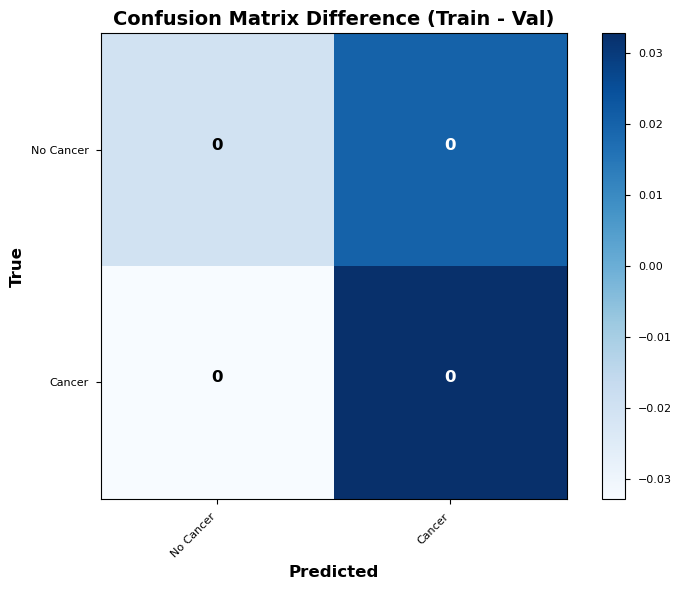

In [ ]:
# ============================================================================
# MAIN EVALUATION EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("STARTING MODEL EVALUATION")
    print("="*70)
    
    # Assuming 'trainer' object exists from the training script
    # If running separately, you need to load the model first
    
    # Create evaluator
    evaluator = CancerEvaluator(
        trainer=trainer,  #  CancerTrainer object
        class_names=['No Cancer', 'Cancer']
    )
    
    # Run comprehensive evaluation
    train_metrics, val_metrics = evaluator.evaluate_all()
    
    print("\n" + "="*70)
    print("✓ EVALUATION COMPLETE!")
    print("="*70)
    print(f"\nResults saved to: {evaluator.results_dir}/")
    print(f"Plots saved to: {evaluator.plots_dir}/")
    print("\nFiles created:")
    print("  - metrics_train.csv")
    print("  - metrics_val.csv")
    print("  - summary.txt")
    print("  - confusion_matrix_train.png")
    print("  - confusion_matrix_val.png")
    print("  - confusion_matrix_train_norm.png")
    print("  - confusion_matrix_val_norm.png")
    print("  - confusion_matrix_diff.png")
    print("  - roc_curves_train.png")
    print("  - roc_curves_val.png")
    print("  - training_curves.png (from training)")
    print("="*70)